# Analyze the behavior of liquidators.

Steps:

1. Load a sample of events from the Google Storage for each of the following protocols: "zklend", "nostra_alpha", "nostra_mainnet", "hashstack_v0", and "hashstack_v1". You can find the sample e.g. for zkLend here: https://storage.googleapis.com/derisk-persistent-state/zklend_data/events_sample.parquet. To obtain the sample for other protocols, just change the folder in the address, e.g. https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/events_sample.parquet for Nostra Alpha. Write the loading part in a way that the source can be easily changed from the Google Storage to a local database.
2. Identify only liquidation events. Use Starkscan to explore their structure. For example, this is one of zkLend's liquidation events. https://starkscan.co/event/0x00a1e829fb091f7493c509135992ac12af6a81177e3ffab5c34951fb29c23084_6
3. Identify the amounts of debt tokens liquidated.
4. Visualize the behavior of all liquidators found in the sample in a Jupyter notebook. You should use the visualizations to answer the following questions:

How many liquidators are there per protocol? Do some of them operate on more than just a single lending protocol?

How many loans has each of them liquidated?

What is the average liquidated debt amount? Compute the averages across all liquidations, but also per protocol and per token amounts.

What is the total amount of the liquidated debt? Compute the total amounts across all liquidations, but also per protocol and per token amounts.

Fetch prices for these tokens (in USD), e.g., from Coingecko. Multiply the token amounts by the corresponding prices to obtain USD nominal amounts and be able to compare the per token stats across tokens.

In [350]:
import requests
import pandas as pd
import pyarrow.parquet as pq
from io import BytesIO
import json
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt


In [322]:
# Dictionary of protocols and corresponding Parquet file URLs
parquet_urls = {
    'zklend': 'https://storage.googleapis.com/derisk-persistent-state/zklend_data/events_sample.parquet',
    'nostra_alpha': 'https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/events_sample.parquet',
    'nostra_mainnet': 'https://storage.googleapis.com/derisk-persistent-state/nostra_mainnet_data/events_sample.parquet',
    'hashstack_v0': 'https://storage.googleapis.com/derisk-persistent-state/hashstack_v0_data/events_sample.parquet',
    'hashstack_v1': 'https://storage.googleapis.com/derisk-persistent-state/hashstack_v1_data/events_sample.parquet'
}

# Dictionary to store dataframes
dataframes_protocol = {}

for protocol, url in parquet_urls.items():
    print(f"Processing {protocol}...")

    # Download the file
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Read the Parquet file into a Pandas DataFrame
    with BytesIO(response.content) as f:
        table = pq.read_table(f)
        df_protocol = table.to_pandas()

        # Add a column for the protocol
        df_protocol['Protocol'] = protocol

        # Store dataframe in dictionary
        dataframes_protocol[protocol] = df_protocol



Processing zklend...
Processing nostra_alpha...
Processing nostra_mainnet...
Processing hashstack_v0...
Processing hashstack_v1...


In [352]:
def load_data_from_google_storage(url):
    """Load data from a Google Storage URL."""
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    with BytesIO(response.content) as f:
        table = pq.read_table(f)
        df = table.to_pandas()
    return df

def load_data_from_local_parquet(file_path):
    """Load data from a local Parquet file."""
    table = pq.read_table(file_path)
    df = table.to_pandas()
    return df

def load_protocol_data(source, config):
    """Load data based on the specified source."""
    dataframes_protocol = {}
    if source == 'google_storage':
        for protocol, url in config.items():
            print(f"Processing {protocol} from Google Storage...")
            df_protocol = load_data_from_google_storage(url)
            df_protocol['Protocol'] = protocol
            dataframes_protocol[protocol] = df_protocol
    elif source == 'local_parquet':
        for protocol, file_path in config.items():
            print(f"Processing {protocol} from local Parquet file...")
            df_protocol = load_data_from_local_parquet(file_path)
            df_protocol['Protocol'] = protocol
            dataframes_protocol[protocol] = df_protocol
    return dataframes_protocol

# Configuration for Google Storage
google_storage_config = {
    'zklend': 'https://storage.googleapis.com/derisk-persistent-state/zklend_data/events_sample.parquet',
    'nostra_alpha': 'https://storage.googleapis.com/derisk-persistent-state/nostra_alpha_data/events_sample.parquet',
    'nostra_mainnet': 'https://storage.googleapis.com/derisk-persistent-state/nostra_mainnet_data/events_sample.parquet',
    'hashstack_v0': 'https://storage.googleapis.com/derisk-persistent-state/hashstack_v0_data/events_sample.parquet',
    'hashstack_v1': 'https://storage.googleapis.com/derisk-persistent-state/hashstack_v1_data/events_sample.parquet'
}

# Configuration for local Parquet files
local_parquet_config = {
    'zklend': 'path_to_local_parquet_files/zklend_data/events_sample.parquet',
    'nostra_alpha': 'path_to_local_parquet_files/nostra_alpha_data/events_sample.parquet',
    'nostra_mainnet': 'path_to_local_parquet_files/nostra_mainnet_data/events_sample.parquet',
    'hashstack_v0': 'path_to_local_parquet_files/hashstack_v0_data/events_sample.parquet',
    'hashstack_v1': 'path_to_local_parquet_files/hashstack_v1_data/events_sample.parquet'
}

# Select the source: 'google_storage' or 'local_parquet'
source = 'google_storage'  # or 'local_parquet'
config = google_storage_config if source == 'google_storage' else local_parquet_config

# Load the data
dataframes_protocol = load_protocol_data(source, config)

# dataframes_protocol
for protocol, df in dataframes_protocol.items():
    print(f"{protocol} dataframe shape: {df.shape}")


Processing zklend from Google Storage...
Processing nostra_alpha from Google Storage...
Processing nostra_mainnet from Google Storage...
Processing hashstack_v0 from Google Storage...
Processing hashstack_v1 from Google Storage...
zklend dataframe shape: (100000, 10)
nostra_alpha dataframe shape: (100000, 10)
nostra_mainnet dataframe shape: (100000, 10)
hashstack_v0 dataframe shape: (780, 11)
hashstack_v1 dataframe shape: (4253, 11)


In [323]:
# 1. ZKLEND

# Liquidation events for the zklend protocol
filtered_df_zklend = dataframes_protocol['zklend'].loc[dataframes_protocol['zklend']["key_name"] == 'Liquidation']
# print(filtered_df_zklend.head())

def getzkLendLiquidator(row):
    row['liquidator'] = json.loads(row['data'])[0]
    row['debt_token'] = json.loads(row['data'])[2]
    row['debt_face_amount'] = json.loads(row['data'])[4]
    return row

# liquidators = df_liquidation[1]
filtered_df_zklend = filtered_df_zklend.apply(getzkLendLiquidator, axis=1)


In [324]:
# Source: https://docs.nostra.finance/lend/deployed-contracts/lend-alpha#asset-contracts.
ADDRESSES_TO_TOKENS: dict[str, str] = {
    '0x0553cea5d1dc0e0157ffcd36a51a0ced717efdadd5ef1b4644352bb45bd35453': 'ETH',
    '0x047e794d7c49c49fd2104a724cfa69a92c5a4b50a5753163802617394e973833': 'USDC',
    '0x003cd2066f3c8b4677741b39db13acebba843bbbaa73d657412102ab4fd98601': 'USDT',
    '0x04403e420521e7a4ca0dc5192af81ca0bb36de343564a9495e11c8d9ba6e9d17': 'DAI',
    '0x06b59e2a746e141f90ec8b6e88e695265567ab3bdcf27059b4a15c89b0b7bd53': 'wBTC',
    '0x070f8a4fcd75190661ca09a7300b7c93fab93971b67ea712c664d7948a8a54c6': 'ETH',
    '0x029959a546dda754dc823a7b8aa65862c5825faeaaf7938741d8ca6bfdc69e4e': 'USDC',
    '0x055ba2baf189b98c59f6951a584a3a7d7d6ff2c4ef88639794e739557e1876f0': 'USDT',
    '0x01ac55cabf2b79cf39b17ba0b43540a64205781c4b7850e881014aea6f89be58': 'DAI',
    '0x00687b5d9e591844169bc6ad7d7256c4867a10cee6599625b9d78ea17a7caef9': 'wBTC',
    '0x040b091cb020d91f4a4b34396946b4d4e2a450dbd9410432ebdbfe10e55ee5e5': 'ETH',
    '0x03b6058a9f6029b519bc72b2cc31bcb93ca704d0ab79fec2ae5d43f79ac07f7a': 'USDC',
    '0x065c6c7119b738247583286021ea05acc6417aa86d391dcdda21843c1fc6e9c6': 'USDT',
    '0x0362b4455f5f4cc108a5a1ab1fd2cc6c4f0c70597abb541a99cf2734435ec9cb': 'DAI',
    '0x075b0d87aca8dee25df35cdc39a82b406168fa23a76fc3f03abbfdc6620bb6d7': 'wBTC',
}
# Source: https://docs.nostra.finance/lend/deployed-contracts/lend-alpha#asset-contracts.
ADDRESSES_TO_EVENTS: dict[str, str] = {
    '0x0553cea5d1dc0e0157ffcd36a51a0ced717efdadd5ef1b4644352bb45bd35453': 'non_interest_bearing_collateral',
    '0x047e794d7c49c49fd2104a724cfa69a92c5a4b50a5753163802617394e973833': 'non_interest_bearing_collateral',
    '0x003cd2066f3c8b4677741b39db13acebba843bbbaa73d657412102ab4fd98601': 'non_interest_bearing_collateral',
    '0x04403e420521e7a4ca0dc5192af81ca0bb36de343564a9495e11c8d9ba6e9d17': 'non_interest_bearing_collateral',
    '0x06b59e2a746e141f90ec8b6e88e695265567ab3bdcf27059b4a15c89b0b7bd53': 'non_interest_bearing_collateral',
    '0x070f8a4fcd75190661ca09a7300b7c93fab93971b67ea712c664d7948a8a54c6': 'interest_bearing_collateral',
    '0x029959a546dda754dc823a7b8aa65862c5825faeaaf7938741d8ca6bfdc69e4e': 'interest_bearing_collateral',
    '0x055ba2baf189b98c59f6951a584a3a7d7d6ff2c4ef88639794e739557e1876f0': 'interest_bearing_collateral',
    '0x01ac55cabf2b79cf39b17ba0b43540a64205781c4b7850e881014aea6f89be58': 'interest_bearing_collateral',
    '0x00687b5d9e591844169bc6ad7d7256c4867a10cee6599625b9d78ea17a7caef9': 'interest_bearing_collateral',
    '0x040b091cb020d91f4a4b34396946b4d4e2a450dbd9410432ebdbfe10e55ee5e5': 'debt',
    '0x03b6058a9f6029b519bc72b2cc31bcb93ca704d0ab79fec2ae5d43f79ac07f7a': 'debt',
    '0x065c6c7119b738247583286021ea05acc6417aa86d391dcdda21843c1fc6e9c6': 'debt',
    '0x0362b4455f5f4cc108a5a1ab1fd2cc6c4f0c70597abb541a99cf2734435ec9cb': 'debt',
    '0x075b0d87aca8dee25df35cdc39a82b406168fa23a76fc3f03abbfdc6620bb6d7': 'debt',
}


In [325]:

# 2. Nostra_alpha 
# Under Nostra, liquidations should be composed of at least 2 Burn events, 
# 1 Burn event for the collateral token and  1 Burn event for the debt token. 
# Both events should have the same user and occurr within the same block_number and`transaction_hash`. 

# Load the dataframe
df = dataframes_protocol['nostra_alpha']

def getnostraLiquidator(row):
    row['user'] = json.loads(row['data'])[0]
    row['amount'] = json.loads(row['data'])[1]
    return row

# Filter out the burn events
burn_events = df[df["key_name"] == 'Burn']

tqdm.pandas()
burn_events = burn_events.progress_apply(getnostraLiquidator, axis=1)


100%|██████████| 14234/14234 [00:30<00:00, 470.52it/s]


In [326]:
# Separate collateral and debt burn events
nostra_burn_collateral = burn_events[burn_events['from_address'].isin([addr for addr, event in ADDRESSES_TO_EVENTS.items() if 'collateral' in event])]
nostra_burn_debt = burn_events[burn_events['from_address'].isin([addr for addr, event in ADDRESSES_TO_EVENTS.items() if event == 'debt'])]

# Merge collateral and debt events on user, block_number, and transaction_hash
merged_burn_events = pd.merge(
    nostra_burn_collateral,
    nostra_burn_debt,
    on=['user', 'block_number', 'transaction_hash'],
    suffixes=('_collateral', '_debt')
)
x = nostra_burn_debt[nostra_burn_debt['transaction_hash'].isin(nostra_burn_collateral['transaction_hash'])]
print(x.shape)

# Display the filtered dataframe
print(merged_burn_events)
filtered_df_nostra_alpha = merged_burn_events


# No liquidations found, i.e. the transaction_hash doesnt match for the burn events. Therefore, cannot be categorised
# as liquidation event 

(0, 12)
Empty DataFrame
Columns: [block_hash_collateral, block_number, transaction_hash, event_index_collateral, from_address_collateral, keys_collateral, data_collateral, timestamp_collateral, key_name_collateral, Protocol_collateral, user, amount_collateral, block_hash_debt, event_index_debt, from_address_debt, keys_debt, data_debt, timestamp_debt, key_name_debt, Protocol_debt, amount_debt]
Index: []

[0 rows x 21 columns]


In [327]:
# Source: https://docs.nostra.finance/lend/deployed-contracts/lend-mainnet#asset-contracts.
ADDRESSES_TO_TOKENS: dict[str, str] = {
    '0x01fecadfe7cda2487c66291f2970a629be8eecdcb006ba4e71d1428c2b7605c7': 'ETH',
    '0x002fc2d4b41cc1f03d185e6681cbd40cced61915d4891517a042658d61cba3b1': 'USDC',
    '0x0360f9786a6595137f84f2d6931aaec09ceec476a94a98dcad2bb092c6c06701': 'USDT',
    '0x022ccca3a16c9ef0df7d56cbdccd8c4a6f98356dfd11abc61a112483b242db90': 'DAI',
    '0x0735d0f09a4e8bf8a17005fa35061b5957dcaa56889fc75df9e94530ff6991ea': 'wBTC',
    '0x00ca44c79a77bcb186f8cdd1a0cd222cc258bebc3bec29a0a020ba20fdca40e9': 'wstETH',
    '0x0507eb06dd372cb5885d3aaf18b980c41cd3cd4691cfd3a820339a6c0cec2674': 'LORDS',
    '0x026c5994c2462770bbf940552c5824fb0e0920e2a8a5ce1180042da1b3e489db': 'STRK',
    '0x078a40c85846e3303bf7982289ca7def68297d4b609d5f588208ac553cff3a18': 'nstSTRK',
    '0x044debfe17e4d9a5a1e226dabaf286e72c9cc36abbe71c5b847e669da4503893': 'ETH',
    '0x05f296e1b9f4cf1ab452c218e72e02a8713cee98921dad2d3b5706235e128ee4': 'USDC',
    '0x0514bd7ee8c97d4286bd481c54aa0793e43edbfb7e1ab9784c4b30469dcf9313': 'USDT',
    '0x005c4676bcb21454659479b3cd0129884d914df9c9b922c1c649696d2e058d70': 'DAI',
    '0x036b68238f3a90639d062669fdec08c4d0bdd09826b1b6d24ef49de6d8141eaa': 'wBTC',
    '0x05eb6de9c7461b3270d029f00046c8a10d27d4f4a4c931a4ea9769c72ef4edbb': 'wstETH',
    '0x02530a305dd3d92aad5cf97e373a3d07577f6c859337fb0444b9e851ee4a2dd4': 'LORDS',
    '0x040f5a6b7a6d3c472c12ca31ae6250b462c6d35bbdae17bd52f6c6ca065e30cf': 'STRK',
    '0x0142af5b6c97f02cac9c91be1ea9895d855c5842825cb2180673796e54d73dc5': 'nstSTRK',
    '0x057146f6409deb4c9fa12866915dd952aa07c1eb2752e451d7f3b042086bdeb8': 'ETH',
    '0x05dcd26c25d9d8fd9fc860038dcb6e4d835e524eb8a85213a8cda5b7fff845f6': 'USDC',
    '0x0453c4c996f1047d9370f824d68145bd5e7ce12d00437140ad02181e1d11dc83': 'USDT', 
    '0x04f18ffc850cdfa223a530d7246d3c6fc12a5969e0aa5d4a88f470f5fe6c46e9': 'DAI',
    '0x05b7d301fa769274f20e89222169c0fad4d846c366440afc160aafadd6f88f0c': 'wBTC',
    '0x009377fdde350e01e0397820ea83ed3b4f05df30bfb8cf8055d62cafa1b2106a': 'wstETH',
    '0x0739760bce37f89b6c1e6b1198bb8dc7166b8cf21509032894f912c9d5de9cbd': 'LORDS',
    '0x07c2e1e733f28daa23e78be3a4f6c724c0ab06af65f6a95b5e0545215f1abc1b': 'STRK',
    '0x067a34ff63ec38d0ccb2817c6d3f01e8b0c4792c77845feb43571092dcf5ebb5': 'nstSTRK',
    '0x00ba3037d968790ac486f70acaa9a1cab10cf5843bb85c986624b4d0e5a82e74': 'ETH',
    '0x063d69ae657bd2f40337c39bf35a870ac27ddf91e6623c2f52529db4c1619a51': 'USDC',
    '0x024e9b0d6bc79e111e6872bb1ada2a874c25712cf08dfc5bcf0de008a7cca55f': 'USDT',
    '0x066037c083c33330a8460a65e4748ceec275bbf5f28aa71b686cbc0010e12597': 'DAI',
    '0x0491480f21299223b9ce770f23a2c383437f9fbf57abc2ac952e9af8cdb12c97': 'wBTC',
    '0x0348cc417fc877a7868a66510e8e0d0f3f351f5e6b0886a86b652fcb30a3d1fb': 'wstETH',
    '0x035778d24792bbebcf7651146896df5f787641af9e2a3db06480a637fbc9fff8': 'LORDS',
    '0x001258eae3eae5002125bebf062d611a772e8aea3a1879b64a19f363ebd00947': 'STRK',
    '0x0292be6baee291a148006db984f200dbdb34b12fb2136c70bfe88649c12d934b': 'nstSTRK',
}
# Source: https://docs.nostra.finance/lend/deployed-contracts/lend-mainnet#asset-contracts.
ADDRESSES_TO_EVENTS: dict[str, str] = {
    '0x01fecadfe7cda2487c66291f2970a629be8eecdcb006ba4e71d1428c2b7605c7': 'interest_bearing_deposit',
    '0x002fc2d4b41cc1f03d185e6681cbd40cced61915d4891517a042658d61cba3b1': 'interest_bearing_deposit',
    '0x0360f9786a6595137f84f2d6931aaec09ceec476a94a98dcad2bb092c6c06701': 'interest_bearing_deposit',
    '0x022ccca3a16c9ef0df7d56cbdccd8c4a6f98356dfd11abc61a112483b242db90': 'interest_bearing_deposit',
    '0x0735d0f09a4e8bf8a17005fa35061b5957dcaa56889fc75df9e94530ff6991ea': 'interest_bearing_deposit',
    '0x00ca44c79a77bcb186f8cdd1a0cd222cc258bebc3bec29a0a020ba20fdca40e9': 'interest_bearing_deposit',
    '0x0507eb06dd372cb5885d3aaf18b980c41cd3cd4691cfd3a820339a6c0cec2674': 'interest_bearing_deposit',
    '0x026c5994c2462770bbf940552c5824fb0e0920e2a8a5ce1180042da1b3e489db': 'interest_bearing_deposit',
    '0x078a40c85846e3303bf7982289ca7def68297d4b609d5f588208ac553cff3a18': 'interest_bearing_deposit',
    '0x044debfe17e4d9a5a1e226dabaf286e72c9cc36abbe71c5b847e669da4503893': 'non_interest_bearing_collateral',
    '0x05f296e1b9f4cf1ab452c218e72e02a8713cee98921dad2d3b5706235e128ee4': 'non_interest_bearing_collateral',
    '0x0514bd7ee8c97d4286bd481c54aa0793e43edbfb7e1ab9784c4b30469dcf9313': 'non_interest_bearing_collateral',
    '0x005c4676bcb21454659479b3cd0129884d914df9c9b922c1c649696d2e058d70': 'non_interest_bearing_collateral',
    '0x036b68238f3a90639d062669fdec08c4d0bdd09826b1b6d24ef49de6d8141eaa': 'non_interest_bearing_collateral',
    '0x05eb6de9c7461b3270d029f00046c8a10d27d4f4a4c931a4ea9769c72ef4edbb': 'non_interest_bearing_collateral',
    '0x02530a305dd3d92aad5cf97e373a3d07577f6c859337fb0444b9e851ee4a2dd4': 'non_interest_bearing_collateral',
    '0x040f5a6b7a6d3c472c12ca31ae6250b462c6d35bbdae17bd52f6c6ca065e30cf': 'non_interest_bearing_collateral',
    '0x0142af5b6c97f02cac9c91be1ea9895d855c5842825cb2180673796e54d73dc5': 'non_interest_bearing_collateral',
    '0x057146f6409deb4c9fa12866915dd952aa07c1eb2752e451d7f3b042086bdeb8': 'interest_bearing_collateral',
    '0x05dcd26c25d9d8fd9fc860038dcb6e4d835e524eb8a85213a8cda5b7fff845f6': 'interest_bearing_collateral',
    '0x0453c4c996f1047d9370f824d68145bd5e7ce12d00437140ad02181e1d11dc83': 'interest_bearing_collateral', 
    '0x04f18ffc850cdfa223a530d7246d3c6fc12a5969e0aa5d4a88f470f5fe6c46e9': 'interest_bearing_collateral',
    '0x05b7d301fa769274f20e89222169c0fad4d846c366440afc160aafadd6f88f0c': 'interest_bearing_collateral',
    '0x009377fdde350e01e0397820ea83ed3b4f05df30bfb8cf8055d62cafa1b2106a': 'interest_bearing_collateral',
    '0x0739760bce37f89b6c1e6b1198bb8dc7166b8cf21509032894f912c9d5de9cbd': 'interest_bearing_collateral',
    '0x07c2e1e733f28daa23e78be3a4f6c724c0ab06af65f6a95b5e0545215f1abc1b': 'interest_bearing_collateral',
    '0x067a34ff63ec38d0ccb2817c6d3f01e8b0c4792c77845feb43571092dcf5ebb5': 'interest_bearing_collateral',
    '0x00ba3037d968790ac486f70acaa9a1cab10cf5843bb85c986624b4d0e5a82e74': 'debt',
    '0x063d69ae657bd2f40337c39bf35a870ac27ddf91e6623c2f52529db4c1619a51': 'debt',
    '0x024e9b0d6bc79e111e6872bb1ada2a874c25712cf08dfc5bcf0de008a7cca55f': 'debt',
    '0x066037c083c33330a8460a65e4748ceec275bbf5f28aa71b686cbc0010e12597': 'debt',
    '0x0491480f21299223b9ce770f23a2c383437f9fbf57abc2ac952e9af8cdb12c97': 'debt',
    '0x0348cc417fc877a7868a66510e8e0d0f3f351f5e6b0886a86b652fcb30a3d1fb': 'debt',
    '0x035778d24792bbebcf7651146896df5f787641af9e2a3db06480a637fbc9fff8': 'debt',
    '0x001258eae3eae5002125bebf062d611a772e8aea3a1879b64a19f363ebd00947': 'debt',
    '0x0292be6baee291a148006db984f200dbdb34b12fb2136c70bfe88649c12d934b': 'debt',
}


In [328]:

# 3. Nostra_mainnet 
# Under Nostra, liquidations should be composed of at least 2 Burn events, 
# 1 Burn event for the collateral token and  1 Burn event for the debt token. 
# Both events should have the same user and occurr within the same block_number and`transaction_hash`. 

# Load the dataframe
df = dataframes_protocol['nostra_mainnet']

def getnostraLiquidator(row):
    row['user'] = json.loads(row['data'])[0]
    row['amount'] = json.loads(row['data'])[1]
    return row

# Filter out the burn events
burn_events = df[df["key_name"] == 'Burn']

tqdm.pandas()
burn_events = burn_events.progress_apply(getnostraLiquidator, axis=1)


100%|██████████| 17779/17779 [00:37<00:00, 471.39it/s]


In [329]:
# Separate collateral and debt burn events
nostra_burn_collateral = burn_events[burn_events['from_address'].isin([addr for addr, event in ADDRESSES_TO_EVENTS.items() if 'collateral' in event])]
nostra_burn_debt = burn_events[burn_events['from_address'].isin([addr for addr, event in ADDRESSES_TO_EVENTS.items() if event == 'debt'])]

# Merge collateral and debt events on user, block_number, and transaction_hash
merged_burn_events = pd.merge(
    nostra_burn_collateral,
    nostra_burn_debt,
    on=['user', 'block_number', 'transaction_hash'],
    suffixes=('_collateral', '_debt')
)
x = nostra_burn_debt[nostra_burn_debt['transaction_hash'].isin(nostra_burn_collateral['transaction_hash'])]
print(x.shape)

# Display the filtered dataframe
print(merged_burn_events)
fitered_df_nostramainnet = merged_burn_events

(0, 12)
Empty DataFrame
Columns: [block_hash_collateral, block_number, transaction_hash, event_index_collateral, from_address_collateral, keys_collateral, data_collateral, timestamp_collateral, key_name_collateral, Protocol_collateral, user, amount_collateral, block_hash_debt, event_index_debt, from_address_debt, keys_debt, data_debt, timestamp_debt, key_name_debt, Protocol_debt, amount_debt]
Index: []

[0 rows x 21 columns]


In [330]:
# 4. hashstack_v0

# Liquidation events for the hashstack_v0 protocol
filtered_df_hashstack_v0 = dataframes_protocol['hashstack_v0']
filtered_df_hashstack_v0 = filtered_df_hashstack_v0[filtered_df_hashstack_v0["key_name"] == 'liquidated']
# print(list(filtered_df_hashstack_v0["transaction_hash"]))

def gethashstackv0Liquidator(row):
#     print(row['data'])
    print(json.loads(row['data'])[4])
    row['liquidator'] = json.loads(row['data'])[14]
    row['debt_face_amount'] = json.loads(row['data'])[4]
    row['debt_token'] = json.loads(row['data'])[2]
    return row

filtered_df_hashstack_v0 = filtered_df_hashstack_v0.apply(gethashstackv0Liquidator, axis=1)

# No liquidations found, i.e. the transaction_hash doesnt match for the burn events. Therefore, cannot be categorised
# as liquidation event 

0x1d6418b
0x9ed07cd
0x1cc4c68


In [331]:
# 5. hashstack_v1
# Assumption:
# The given data does not have liquidation event. So I have used the data from loan_repaid and loan_transferred events
# to get the liquidation data. With liquidation event data the data mining would be much simpler. 
# If liquidation event was known, actual liquidator would have known. Here I assumed the loan reciever as the liquidator. 

# Liquidation events for the hashstack_v1 protocol
filtered_df_hashstack_v1 = dataframes_protocol['hashstack_v1']
# print(list(filtered_df_hashstack_v1["transaction_hash"]))

filtered_df_hashstack_v1_repaid = filtered_df_hashstack_v1[filtered_df_hashstack_v1["key_name"] == 'loan_repaid' ]
filtered_df_hashstack_v1_transferred = filtered_df_hashstack_v1[filtered_df_hashstack_v1["key_name"] == 'loan_transferred' ]
# print(list(filtered_df_hashstack_v1['transaction_hash']))

# address is dToken (e.g. dBTC)
# underlying_asset is token used to give loan in (i.e. BTC)

hashstack_debt_token_to_underlying_map = {
    '0x2614c784267d2026042ab98588f90efbffaade8982567e93530db4ed41201cf': '0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac',
    '0x1ef7f9f8bf01678dc6d27e2c26fb7e8eac3812a24752e6a1d6a49d153bec9f3': '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7',
    '0x12b8185e237dd0340340faeb3351dbe53f8a42f5a9bf974ddf90ced56e301c7': '0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8',
    '0x21d8d8519f5464ec63c6b9a80a5229c5ddeed57ecded4c8a9dfc34e31b49990': '0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8',
    '0x7eeed99c095f83716e465e2c52a3ec8f47b323041ddc4f97778ac0393b7f358': '0xda114221cb83fa859dbdb4c44beeaa0bb37c7537ad5ae66fe5e0efd20e6eb3',
    '0x1bdbaaa456c7d6bbba9ff740af3cfcd40bec0e85cd5cefc3fbb05a552fd14df': '0x4718f5a0fc34cc1af16a1cdee98ffb20c31f5cd61d6ab07201858f4287c938d',

}

# from loan_repaid event
def gethashstackv1debt(row):
#     print(json.loads(row['data'])[2])
    row['debt_face_amount'] = json.loads(row['data'])[29]
    dToken = json.loads(row['data'])[2]
    row['debt_token'] = hashstack_debt_token_to_underlying_map[dToken]
    row['loan_id'] = json.loads(row['data'])[0]
    return row

# from loan_transffered event
def gethashstackv1Liquidator(row):
#     print(json.loads(row['data'])[0])
    row['loan_id'] = json.loads(row['data'])[0]
    row['liquidator'] = json.loads(row['data'])[2]
    return row

filtered_df_hashstack_v1_repaid = filtered_df_hashstack_v1_1.apply(gethashstackv1debt, axis=1) # loan_repaid event 
filtered_df_hashstack_v1_transferred = filtered_df_hashstack_v1_2.apply(gethashstackv1Liquidator, axis=1) # loan_transferred event 
print(filtered_df_hashstack_v1_repaid.shape)
print(filtered_df_hashstack_v1_transferred.shape)


# Assuming filtered_df_hashstack_v1_repaid and filtered_df_hashstack_v1_transferred are defined and processed
# Merge the dataframes on the 'loan_id' column
common_loanid_df = pd.merge(filtered_df_hashstack_v1_repaid, filtered_df_hashstack_v1_transferred, on='loan_id', suffixes=('_repaid', '_transferred'))

# Display the shape and first few rows of the new dataframe
print("commonid",common_loanid_df.shape)
# print(common_loanid_df.head())

# Optional: Verify the number of unique loan_id values to ensure there are 51 common loan_ids
# print("Number of unique loan_ids in the merged dataframe:", common_loans_df['loan_id'].nunique())


# As the timestamps are the same, we can drop one of them
common_loanid_df['timestamp'] = common_loanid_df['timestamp_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['timestamp_repaid', 'timestamp_transferred'])
# As the timestamps are the same, we can drop one of them
common_loanid_df['Protocol'] = common_loanid_df['Protocol_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['Protocol_repaid', 'Protocol_transferred'])
# As the timestamps are the same, we can drop one of them
common_loanid_df['transaction_hash'] = common_loanid_df['transaction_hash_repaid']  # or 'timestamp_transferred'
common_loanid_df = common_loanid_df.drop(columns=['transaction_hash_repaid', 'transaction_hash_transferred'])
# Display the resulting dataframe
filtered_df_hstk_v1 = common_loanid_df
print(filtered_df_hstk_v1.columns)
print(list[filtered_df_hstk_v1["transaction_hash"].shape])



(1279, 15)
(51, 13)
commonid (51, 27)
Index(['block_hash_repaid', 'block_number_repaid', 'event_index_repaid',
       'from_address_repaid', 'keys_repaid', 'data_repaid', 'key_name_repaid',
       'order_repaid', 'debt_face_value', 'debt_token', 'loan_id',
       'debt_face_amount', 'block_hash_transferred',
       'block_number_transferred', 'event_index_transferred',
       'from_address_transferred', 'keys_transferred', 'data_transferred',
       'key_name_transferred', 'order_transferred', 'liquidator', 'timestamp',
       'Protocol', 'transaction_hash'],
      dtype='object')
list[51]


In [332]:
# Stack the DataFrames on top of each other

# for nostra there are no liquidation events found for the given data. Once the data is aquired can add to the vertical
# stack

column_names = ['timestamp', 'debt_token', 'liquidator', 'debt_face_amount', 'Protocol']
vertical_stack = pd.concat(
                [filtered_df_zklend[column_names],
                 filtered_df_hashstack_v0[column_names], 
                 filtered_df_hstk_v1[column_names]], axis=0)



# 1a. Number of liquidations per protocol

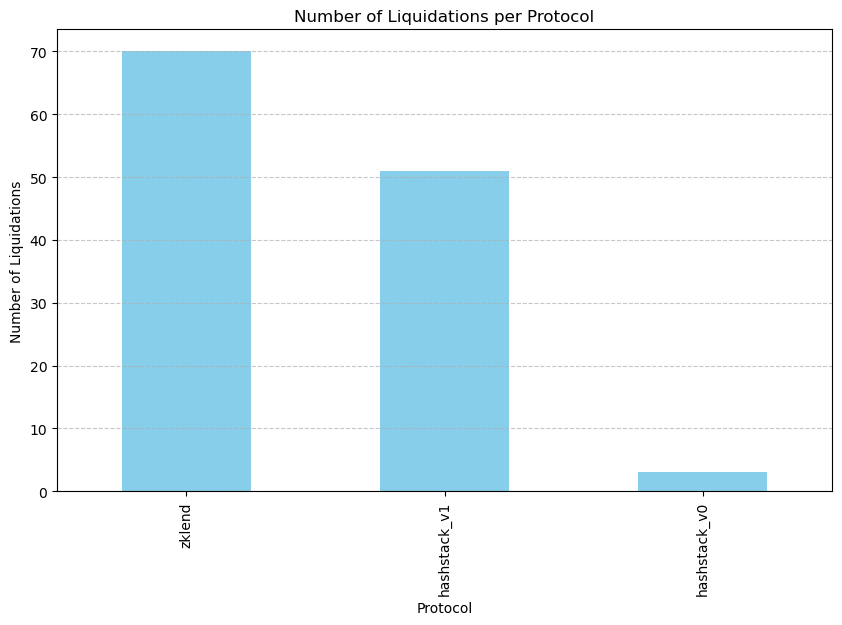

In [333]:
# Calculate the number of liquidations per protocol
liquidation_counts = vertical_stack['Protocol'].value_counts()
# Plot the number of liquidations per protocol
plt.figure(figsize=(10, 6))
liquidation_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Liquidations per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Liquidations')
# plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# 1b. Number of liquidators per protocol

Unique Liquidators per Protocol:
Protocol
hashstack_v0    1
hashstack_v1    1
zklend          1
Name: liquidator, dtype: int64
Cross protocol liquidators (Liquidators operating on multiple protocols): 0


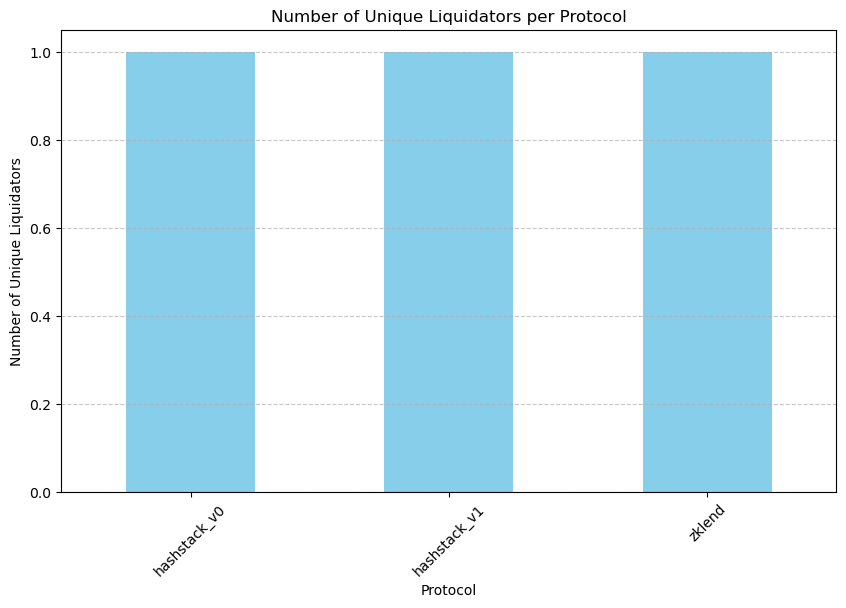

In [334]:
# Number of unique liquidators per protocol
# print('total data', list(vertical_stack['liquidator'].unique()))
unique_liquidators_per_protocol = vertical_stack.groupby('Protocol')['liquidator'].nunique()
print("Unique Liquidators per Protocol:")
print(unique_liquidators_per_protocol)

# Liquidators operating on multiple protocols
liquidator_protocols = vertical_stack.groupby('liquidator')['Protocol'].nunique()
cross_protocol_liquidators = liquidator_protocols[liquidator_protocols > 1]
print("Cross protocol liquidators (Liquidators operating on multiple protocols):", cross_protocol_liquidators.size)

# Plot the number of unique liquidators per protocol
plt.figure(figsize=(10, 6))
unique_liquidators_per_protocol.plot(kind='bar', color='skyblue')
plt.title('Number of Unique Liquidators per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Unique Liquidators')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 2. Loans liquidated by each liquidator

Number of Loans Liquidated by Each Liquidator:
0x4746c68f5f6d6bff7a16fdad6f543750bd6e46a7c00a9e5bb6820c86347fda0    70
0x1b862c518939339b950d0d21a3d4cc8ead102d6270850ac8544636e558fab68    51
0x3dcf5c72ba60eb7b2fe151032769d49dd3df6b04fa3141dffd6e2aa162b7a6e     3
Name: liquidator, dtype: int64


C:\Users\molak\AppData\Local\Temp\ipykernel_22428\2472324274.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_liquidators))


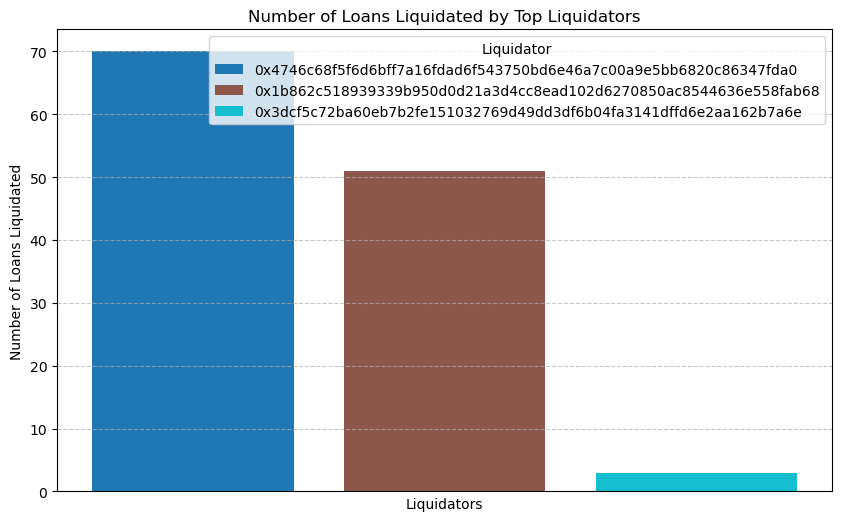

In [348]:
# Number of loans liquidated by each liquidator
loans_per_liquidator = vertical_stack['liquidator'].value_counts()
print("Number of Loans Liquidated by Each Liquidator:")
print(loans_per_liquidator)

# Plot the number of loans liquidated by top liquidators
top_liquidators = loans_per_liquidator.head(10)  # Display top 10 liquidators

# Create a color palette
colors = plt.cm.get_cmap('tab10', len(top_liquidators))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(top_liquidators.index, top_liquidators.values, color=[colors(i) for i in range(len(top_liquidators))])

# Add legend
for bar, liquidator in zip(bars, top_liquidators.index):
    bar.set_label(liquidator)

plt.title('Number of Loans Liquidated by Top Liquidators')
plt.xlabel('Liquidators')
plt.ylabel('Number of Loans Liquidated')
plt.xticks([])  # Remove x-tick labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Liquidator')
plt.show()


# Finding USD price of the debt tokens using yfinance 

In [354]:
# Convert the timestamp to datetime and extract the date part

column_names = ['timestamp', 'debt_token', 'liquidator', 'debt_face_amount', 'Protocol', 'transaction_hash' ]
vertical_stack = pd.concat(
                [filtered_df_zklend[column_names],
                 filtered_df_hashstack_v0[column_names], 
                 filtered_df_hstk_v1[column_names]], axis=0)

vertical_stack['timestamp'] = pd.to_datetime(vertical_stack['timestamp'], unit='s')
vertical_stack['date'] = vertical_stack['timestamp'].dt.date

# Retrieve daily historical data for the past 3 years
ETH_price = yf.download("ETH-USD", interval='1d', period='3y')
USDC_price = yf.download("USDC-USD", interval='1d', period='3y')
USDT_price = yf.download("USDT-USD", interval='1d', period='3y')
BTC_price = yf.download("BTC-USD", interval='1d', period='3y')

# Extract the date part from the price dataframes index
ETH_price['date'] = ETH_price.index.date
USDC_price['date'] = USDC_price.index.date
USDT_price['date'] = USDT_price.index.date
BTC_price['date'] = BTC_price.index.date

# Rename columns to avoid conflicts
ETH_price.rename(columns={'Adj Close': 'Adj_Close_ETH'}, inplace=True)
USDC_price.rename(columns={'Adj Close': 'Adj_Close_USDC'}, inplace=True)
USDT_price.rename(columns={'Adj Close': 'Adj_Close_USDT'}, inplace=True)
BTC_price.rename(columns={'Adj Close': 'Adj_Close_BTC'}, inplace=True)

# Merge prices into the vertical_stack dataframe on the date
vertical_stack_1 = vertical_stack.merge(ETH_price[['date', 'Adj_Close_ETH']], on='date', how='left')
vertical_stack_2 = vertical_stack_1.merge(USDC_price[['date', 'Adj_Close_USDC']], on='date', how='left')
vertical_stack_3 = vertical_stack_2.merge(USDT_price[['date', 'Adj_Close_USDT']], on='date', how='left')
vertical_stack_final = vertical_stack_3.merge(BTC_price[['date', 'Adj_Close_BTC']], on='date', how='left')

# print(vertical_stack_final.columns)

# Define token info
token_info = {
    '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7': ["ETH", 18],
    '0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8': ["USDC", 6],
    '0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8': ["USDT", 6],
    '0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac': ["BTC", 18]
}

# Function to convert hex string to integer and calculate USD value
def hex_to_int(row):
    token = row['debt_token']
    decimal = token_info[token][1]
    face_amount = int(row['debt_face_amount'], 0) / (10**decimal)

    if token_info[token][0] == "ETH":
#         print(row)
        token_price = row['Adj_Close_ETH']
    elif token_info[token][0] == "USDC":
        token_price = row['Adj_Close_USDC']
    elif token_info[token][0] == "USDT":
        token_price = row['Adj_Close_USDT']
    elif token_info[token][0] == "BTC":
        token_price = row['Adj_Close_BTC']
    else:
        token_price = None  # handle unknown token
    
    return face_amount * token_price if token_price else None

# Apply the function to the dataframe and create a new column
vertical_stack_final['debt_usd_value'] = vertical_stack_final.apply(hex_to_int, axis=1)

# print(vertical_stack_final[vertical_stack_final['Protocol'] == 'hashstack_v1'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# 3 Average liquidated debt

In [337]:
# Average liquidated debt amount across all liquidations
average_debt_all = vertical_stack_final['debt_usd_value'].mean()
print("Average Liquidated Debt Amount (All):", average_debt_all)

# Average liquidated debt amount per protocol
average_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].mean()
print("\nAverage Liquidated Debt Amount per Protocol:")
print(average_debt_per_protocol)

# Average liquidated debt amount per token
average_debt_per_token = vertical_stack_final.groupby('debt_token')['debt_usd_value'].mean()
print("\nAverage Liquidated Debt Amount per Token:")
print(average_debt_per_token)


Average Liquidated Debt Amount (All): 271.4080187782815

Average Liquidated Debt Amount per Protocol:
Protocol
hashstack_v0     75.856113
hashstack_v1    649.490061
zklend            4.329041
Name: debt_usd_value, dtype: float64

Average Liquidated Debt Amount per Token:
debt_token
0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac    2.739593e-09
0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7    1.818003e+02
0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8    3.420048e+02
0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8    1.026264e+03
Name: debt_usd_value, dtype: float64


# 4. Total liquidated debt

In [338]:
# Total liquidated debt amount across all liquidations
total_debt_all = vertical_stack_final['debt_usd_value'].sum()
print("Total Liquidated Debt Amount (All):", total_debt_all)

# Total liquidated debt amount per protocol
total_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].sum()
print("\nTotal Liquidated Debt Amount per Protocol:")
print(total_debt_per_protocol)

# Total liquidated debt amount per token
total_debt_per_token = vertical_stack_final.groupby('debt_token')['debt_usd_value'].sum()
print("\nTotal Liquidated Debt Amount per Token:")
print(total_debt_per_token)


Total Liquidated Debt Amount (All): 33654.5943285069

Total Liquidated Debt Amount per Protocol:
Protocol
hashstack_v0      227.568340
hashstack_v1    33123.993091
zklend            303.032898
Name: debt_usd_value, dtype: float64

Total Liquidated Debt Amount per Token:
debt_token
0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac    5.479186e-09
0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7    1.381682e+04
0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8    1.368019e+04
0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8    6.157583e+03
Name: debt_usd_value, dtype: float64


# Visualization of Average and Total Liquidated Debt Amount


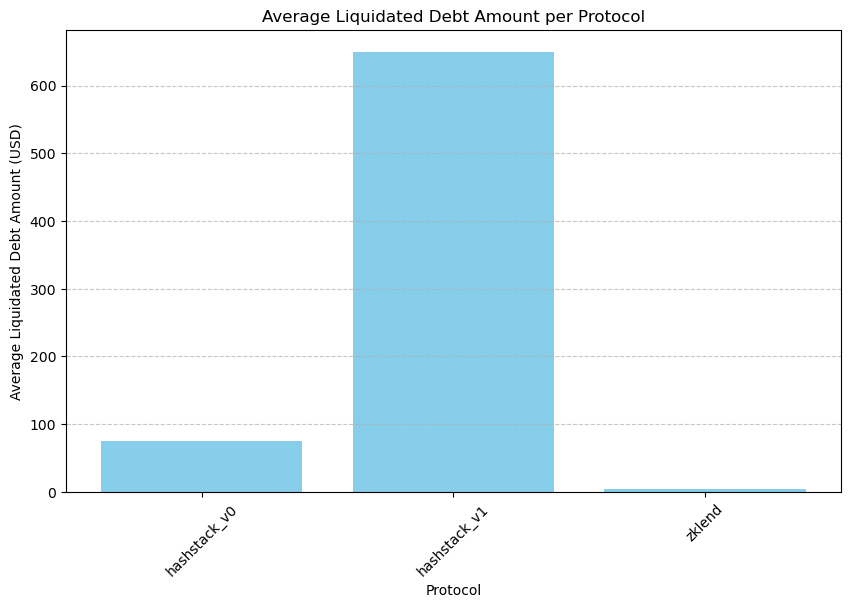

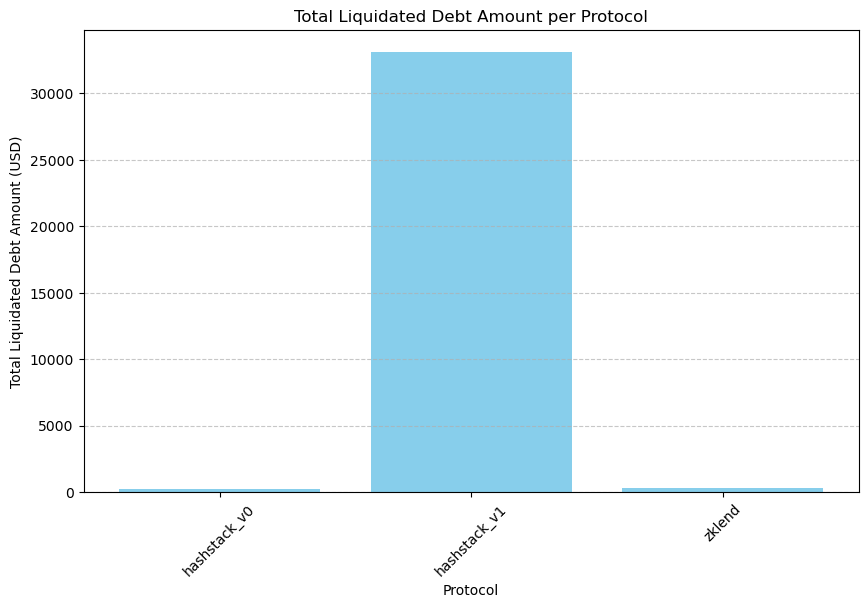

In [339]:

# Calculate the average liquidated debt amount per protocol
average_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].mean()

# Plot average liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(average_debt_per_protocol.index, average_debt_per_protocol.values, color='skyblue')
plt.title('Average Liquidated Debt Amount per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Average Liquidated Debt Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Calculate the total liquidated debt amount per protocol
total_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].sum()

# Plot total liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(total_debt_per_protocol.index, total_debt_per_protocol.values, color='skyblue')
plt.title('Total Liquidated Debt Amount per Protocol')
plt.xlabel('Protocol')
plt.ylabel('Total Liquidated Debt Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


C:\Users\molak\AppData\Local\Temp\ipykernel_22428\2454711500.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(average_debt_per_protocol.index)
C:\Users\molak\AppData\Local\Temp\ipykernel_22428\2454711500.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(total_debt_per_protocol.index)


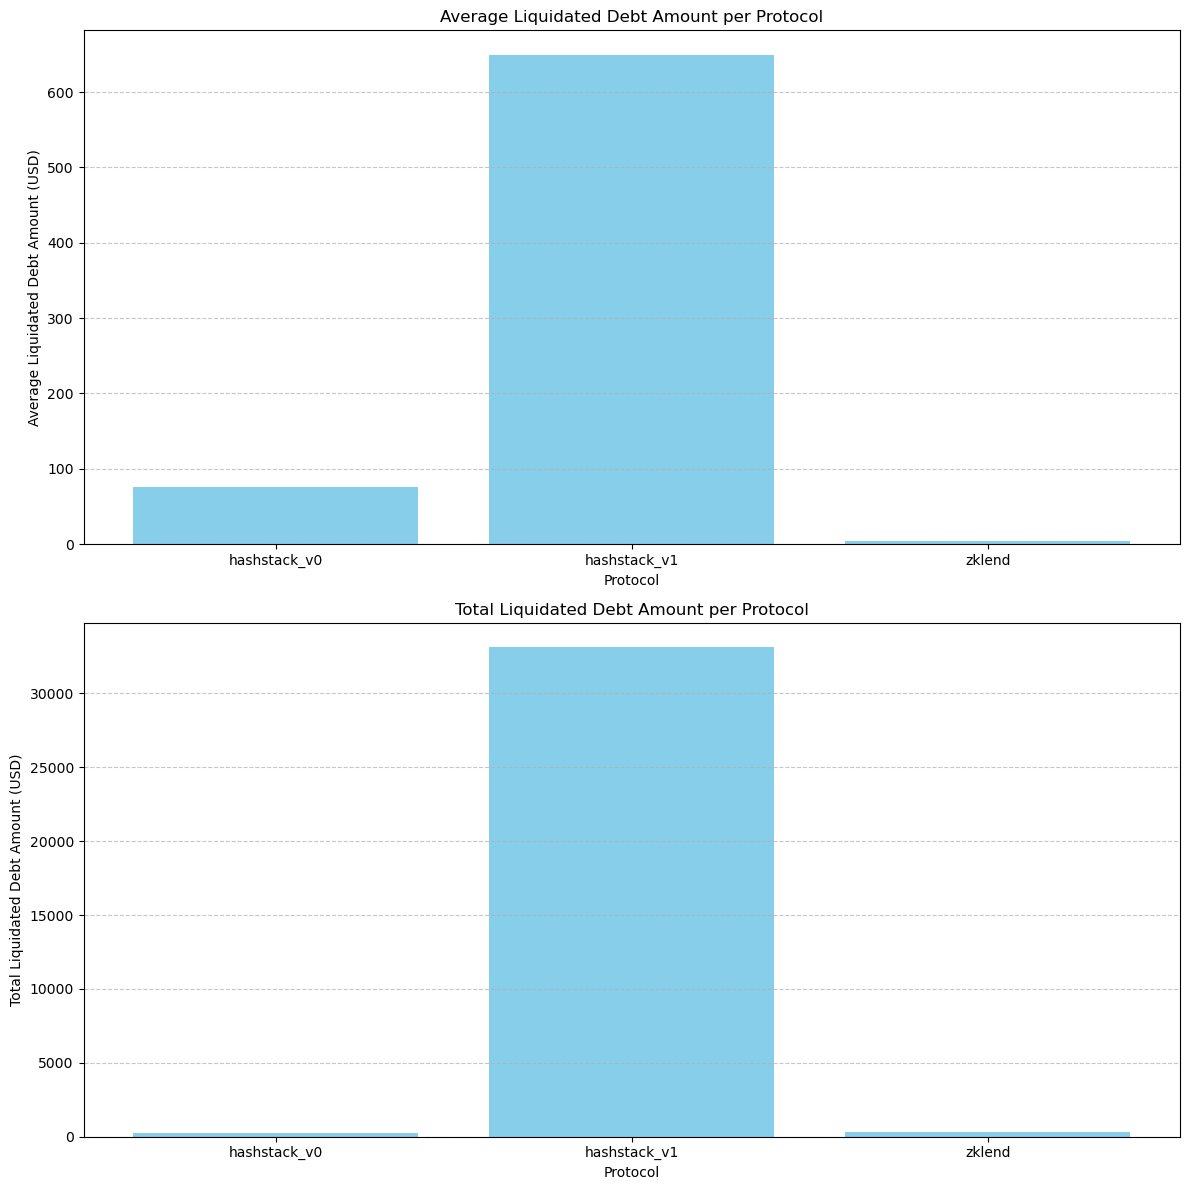

In [340]:
import matplotlib.pyplot as plt

# Calculate the average liquidated debt amount per protocol
average_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].mean()

# Calculate the total liquidated debt amount per protocol
total_debt_per_protocol = vertical_stack_final.groupby('Protocol')['debt_usd_value'].sum()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot average liquidated debt amount per protocol
axes[0].bar(average_debt_per_protocol.index, average_debt_per_protocol.values, color='skyblue')
axes[0].set_title('Average Liquidated Debt Amount per Protocol')
axes[0].set_xlabel('Protocol')
axes[0].set_ylabel('Average Liquidated Debt Amount (USD)')
axes[0].set_xticklabels(average_debt_per_protocol.index)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot total liquidated debt amount per protocol
axes[1].bar(total_debt_per_protocol.index, total_debt_per_protocol.values, color='skyblue')
axes[1].set_title('Total Liquidated Debt Amount per Protocol')
axes[1].set_xlabel('Protocol')
axes[1].set_ylabel('Total Liquidated Debt Amount (USD)')
axes[1].set_xticklabels(total_debt_per_protocol.index)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()


# Total and average debts liquidated per token

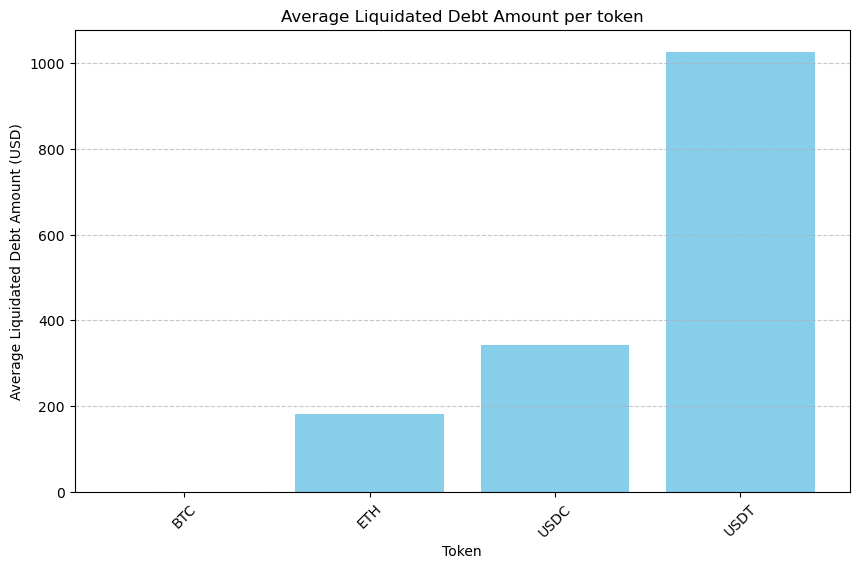

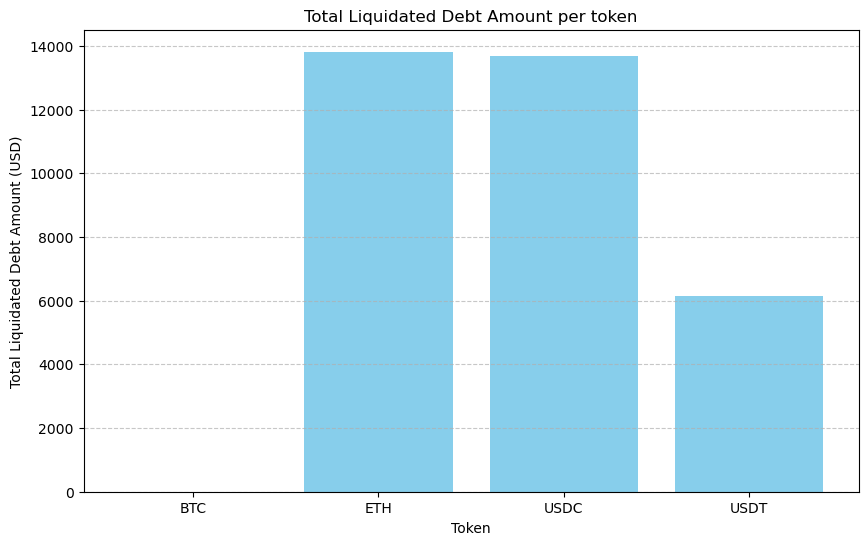

In [341]:
# Calculate the average liquidated debt amount per protocol
average_debt_per_protocol = vertical_stack_final.groupby('debt_token')['debt_usd_value'].mean()
token_names = [token_info[token][0] for token in total_debt_per_token.index]

# Plot average liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(token_names, average_debt_per_protocol.values, color='skyblue')
plt.title('Average Liquidated Debt Amount per token')
plt.xlabel('Token')
plt.ylabel('Average Liquidated Debt Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Calculate the total liquidated debt amount per protocol
total_debt_per_protocol = vertical_stack_final.groupby('debt_token')['debt_usd_value'].sum()

# Plot total liquidated debt amount per protocol
plt.figure(figsize=(10, 6))
plt.bar(token_names, total_debt_per_protocol.values, color='skyblue')
plt.title('Total Liquidated Debt Amount per token')
plt.xlabel('Token')
plt.ylabel('Total Liquidated Debt Amount (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Additionally, plotted the distribution of debt tokens across protocols 

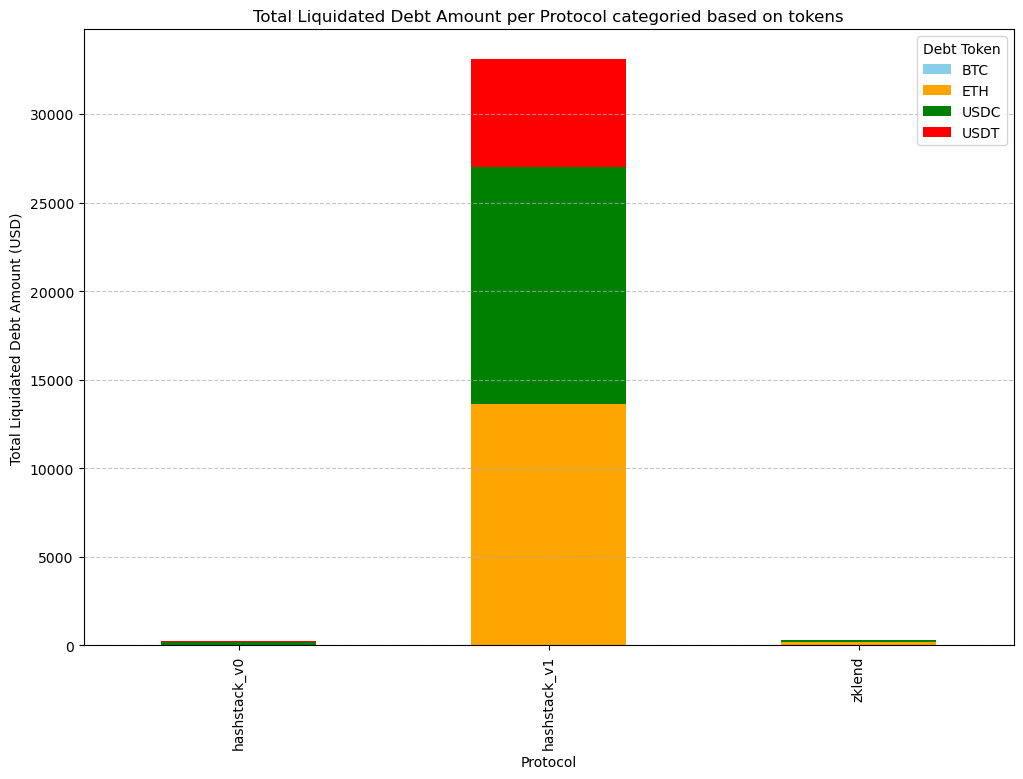

In [347]:
# Aggregate the data by Protocol and debt_token
aggregated_data = vertical_stack_final.groupby(['Protocol', 'debt_token'])['debt_usd_value'].sum().unstack().fillna(0)

# Define token info for names
token_info = {
    '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7': "ETH",
    '0x53c91253bc9682c04929ca02ed00b3e423f6710d2ee7e0d5ebb06f3ecf368a8': "USDC",
    '0x68f5c6a61780768455de69077e07e89787839bf8166decfbf92b645209c0fb8': "USDT",
    '0x3fe2b97c1fd336e750087d68b9b867997fd64a2661ff3ca5a7c771641e8e7ac': "BTC"
}

# Rename columns to human-readable token names
aggregated_data.rename(columns=token_info, inplace=True)

# Plot stacked bar plot
aggregated_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Total Liquidated Debt Amount per Protocol categoried based on tokens')
plt.xlabel('Protocol')
plt.ylabel('Total Liquidated Debt Amount (USD)')
plt.legend(title='Debt Token')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Observations
1. Zklend data is for 3 days, yet 70 liquidation events were seen 
2. Hashstack v1 data time range is from 2023-11-30 to 2024-05-25 (yy-mm-dd), low frequency of liquidations events 
3. The liquidation amount in USD is highest for the hashstack V1
4. During a low span multiple small liquidation events can be seen in zklend
5. Highest liquidation amount in USD is from ETH and USDC followed by USDT, and negligible from BTC

